In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# PreProcessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from category_encoders import BinaryEncoder

# Splitting Data
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

# Tuning
from sklearn.model_selection import GridSearchCV

# Deployment
import pickle

References:
- https://osmihelp.org/research/
- https://www.who.int/teams/mental-health-and-substance-use/mental-health-in-the-workplace#:~:text=Workplaces%20that%20promote%20mental%20health,and%20disorders%20in%20the%20workplace.
- https://www.sciencedaily.com/releases/2019/08/190810151933.htm
- https://www.heretohelp.bc.ca/q-and-a/whats-the-difference-between-mental-health-and-mental-illness
- https://www.mentalhealth.org.uk/publications/how-support-mental-health-work
- https://www.centreformentalhealth.org.uk/some-people-have-mental-health-difficulties-dont-go-away-so-why-do-we-provide-care-and-support-does
- https://www.cdc.gov/workplacehealthpromotion/tools-resources/workplace-health/mental-health/index.html


In [4]:
pd.set_option("display.max_rows", None)
mh = pd.read_csv('/Users/zaki/Downloads/survey.csv')
mh.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


* This raw dataset is from a survey in 2014 that contains 27 columns.
* https://osmihelp.org/research / https://www.kaggle.com/osmi/mental-health-in-tech-survey
* Open Sourcing Mental Illness is a non-profit, 501(c)(3) corporation dedicated to raising awareness, educating, and providing resources to support mental wellness in the tech and open source communities. EIN: 81-3587896

In [5]:
mh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

# Data Cleaning

***Missing Value***

In [6]:
mh.isna().sum()/len(mh.index)*100

Timestamp                     0.000000
Age                           0.000000
Gender                        0.000000
Country                       0.000000
state                        40.905481
self_employed                 1.429706
family_history                0.000000
treatment                     0.000000
work_interfere               20.969023
no_employees                  0.000000
remote_work                   0.000000
tech_company                  0.000000
benefits                      0.000000
care_options                  0.000000
wellness_program              0.000000
seek_help                     0.000000
anonymity                     0.000000
leave                         0.000000
mental_health_consequence     0.000000
phys_health_consequence       0.000000
coworkers                     0.000000
supervisor                    0.000000
mental_health_interview       0.000000
phys_health_interview         0.000000
mental_vs_physical            0.000000
obs_consequence          

* Based on missing value checking, I decided to drop state and comments columns on the next step because it has more than 40% of missing values.

***Drop Columns***

In [7]:
mh.drop(columns=['Timestamp', 'Country', 'state', 'comments'], inplace = True)

- Drop Timestamp column because it's contains date, month, year and time the respondent took this questionnaire, which is irrelevant.
- Drop Country column because it's contained with the country where respondents live and 60% of answer in domination in 1 country. This column becomes irrelevant to the prediction model.
- Drop state column because it's only filled if the respondent lives in the US state, which means other respondents outside the US don't have any state ID and become missing values with 40% of data.
- Drop comments column because almost 70% of data is missing. It was an optional text box so it's reasonable to expect that many (most) respondents would leave it blank.

***Rename Columns***

In [8]:
mh.rename({'self_employed' : 'Self_Employed', 'family_history' : 'Family_History', 
           'treatment' : 'Treatment', 'work_interfere' : 'Work_Interfere', 
           'no_employees': 'Employee_Numbers', 'remote_work': 'Remote_Work', 'tech_company': 'Tech_Company', 
           'benefits': 'Benefits', 'care_options': 'Care_Options', 'wellness_program': 'Wellness_Program', 
           'seek_help': 'Seek_Help', 'anonymity': 'Anonymity', 'leave': 'Medical_Leave', 
           'mental_health_consequence': 'Mental_Health_Consequence', 
           'phys_health_consequence': 'Physical_Health_Consequence', 'coworkers': 'Coworkers', 
           'supervisor': 'Supervisor', 'mental_health_interview': 'Mental_Health_Interview', 
           'phys_health_interview': 'Physical_Health_Interview', 'mental_vs_physical': 'Mental_VS_Physical', 
           'obs_consequence': 'Observed_Consequence'} , inplace = True , axis = 1)

* Rename features name to make it easier while seeing all columns.

***Feature's Value Checking***

* In this section, I process the value of columns that not suitable to neatly arranged.
* The ILO (International Labor Organization) has set a minimum age limit, 15 (fifteen) years which applies in all sectors and becomes a boundary for set the Age column.
* For the Age column, I change the incorrect value into Nan and filled it with Iterative Imputer on ColumnTransformer. Why do I choose to fill it with Iterative Imputer? The Iterative Imputer uses an algorithm by seeing the entire dataset from the available feature column to account for the missing values. 
* For the Gender column has 49 distinct responses. I rename and combine if it's in the same meaning, so it will trim the data and separate it into following categories:
    * Male, or cis Male, means born as male and decide to be male.
    * Female, or cis Female, means born as female and decide to be female.
    * Queer, is a word that describes sexual and gender identities other than straight and cisgender. Lesbian, gay, bisexual, and transgender people may all identify with the word queer.

*Age*

In [9]:
mh['Age'].unique()

array([         37,          44,          32,          31,          33,
                35,          39,          42,          23,          29,
                36,          27,          46,          41,          34,
                30,          40,          38,          50,          24,
                18,          28,          26,          22,          19,
                25,          45,          21,         -29,          43,
                56,          60,          54,         329,          55,
       99999999999,          48,          20,          57,          58,
                47,          62,          51,          65,          49,
             -1726,           5,          53,          61,           8,
                11,          -1,          72])

In [10]:
mh['Age'].replace([mh['Age'][mh['Age'] < 15]], np.nan, inplace = True)
mh['Age'].replace([mh['Age'][mh['Age'] > 100]], np.nan, inplace = True)

mh['Age'].unique()

array([37., 44., 32., 31., 33., 35., 39., 42., 23., 29., 36., 27., 46.,
       41., 34., 30., 40., 38., 50., 24., 18., 28., 26., 22., 19., 25.,
       45., 21., nan, 43., 56., 60., 54., 55., 48., 20., 57., 58., 47.,
       62., 51., 65., 49., 53., 61., 72.])

*Gender*

In [11]:
mh['Gender'].unique()

array(['Female', 'M', 'Male', 'male', 'female', 'm', 'Male-ish', 'maile',
       'Trans-female', 'Cis Female', 'F', 'something kinda male?',
       'Cis Male', 'Woman', 'f', 'Mal', 'Male (CIS)', 'queer/she/they',
       'non-binary', 'Femake', 'woman', 'Make', 'Nah', 'All', 'Enby',
       'fluid', 'Genderqueer', 'Female ', 'Androgyne', 'Agender',
       'cis-female/femme', 'Guy (-ish) ^_^', 'male leaning androgynous',
       'Male ', 'Man', 'Trans woman', 'msle', 'Neuter', 'Female (trans)',
       'queer', 'Female (cis)', 'Mail', 'cis male', 'A little about you',
       'Malr', 'p', 'femail', 'Cis Man',
       'ostensibly male, unsure what that really means'], dtype=object)

In [12]:
mh['Gender'].replace(['Male ', 'male', 'M', 'm', 'Male', 'Cis Male',
                     'Man', 'cis male', 'Mail', 'Male-ish', 'Male (CIS)',
                      'Cis Man', 'msle', 'Malr', 'Mal', 'maile', 'Make',], 'Male', inplace = True)

mh['Gender'].replace(['Female ', 'female', 'F', 'f', 'Woman', 'Female',
                     'femail', 'Cis Female', 'cis-female/femme', 'Femake', 'Female (cis)',
                     'woman',], 'Female', inplace = True)

mh["Gender"].replace(['Female (trans)', 'queer/she/they', 'non-binary',
                     'fluid', 'queer', 'Androgyne', 'Trans-female', 'male leaning androgynous',
                      'Agender', 'A little about you', 'Nah', 'All',
                      'ostensibly male, unsure what that really means',
                      'Genderqueer', 'Enby', 'p', 'Neuter', 'something kinda male?',
                      'Guy (-ish) ^_^', 'Trans woman',], 'Queer', inplace = True)

In [13]:
mh['Gender'].value_counts()

Male      991
Female    247
Queer      21
Name: Gender, dtype: int64

# Dataset

* This is the data set that I use for the next step.

In [14]:
mh.head()

,Age,Gender,Self_Employed,Family_History,Treatment,Work_Interfere,Employee_Numbers,Remote_Work,Tech_Company,Benefits,...,Anonymity,Medical_Leave,Mental_Health_Consequence,Physical_Health_Consequence,Coworkers,Supervisor,Mental_Health_Interview,Physical_Health_Interview,Mental_VS_Physical,Observed_Consequence
0,37.0,Female,NaN,No,Yes,Often,6-25,No,Yes,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44.0,Male,NaN,No,No,Rarely,More than 1000,No,No,Don't know,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32.0,Male,NaN,No,No,Rarely,6-25,No,Yes,No,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31.0,Male,NaN,Yes,Yes,Often,26-100,No,Yes,No,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31.0,Male,NaN,No,No,Never,100-500,Yes,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


* Dataset have 23 columns of features and 1259 rows (values - candidates, who answered the survey questions).

# EDA

Open Sourcing Mental Illness is a non-profit, corporation dedicated to raising awareness, educating, and providing resources to support mental wellness in the tech and open source communities. OSMI began in 2013, with Ed Finkler speaking at tech conferences about his personal experiences as a web developer and open source advocate with a mental health disorder. The response was overwhelming, and thus OSMI was born.

- Every year, OSMI came out with a new survey to see how employees want to get mental health treatment in tech companies around the world and I pick the survey from 2014.


- This survey is filled by respondents who suffer from mental health disorders (diagnose or un-diagnosed by medical, even it's just a feeling) in tech companies and see if any factors can affect the employee to get treatment or not.


- From this research, this machine learning can help HR to see what factors have the company needs to support so the employee wants to get mental health treatment.


#### Target of Data
- **Treatment**: Have you *get treatment for a mental health condition*?
    - (*categorical*: Yes, No)
    
### Features that I use:
- **Age**
    - (*numeric*)
- **Gender**
    - (*categorical*: Male, Female)
- **Self Employed**: Are you self-employed?
    - (*categorical*: Yes, No)
- **Family History**: Do you have a family history of mental illness?
    - (*categorical*: Yes, No)
- **Work Interfere**: If you *have a mental health condition*, do you feel that it *interferes with your work*?
    - (*categorical*: Often, Sometimes, Rarely, Never)
- **Employee Numbers**: How many *employees does your company* or organization have?
    - (*categorical*: 1-5, 6-25, 26-100, 100-500, 500-1000, More than 1000) 
- **Remote Work**: Do you *work remotely* (outside of an office) *at least 50% of the time*?
    - (*categorical*: Yes, No)
- **Tech Company**: Is your employer *primarily a tech company/organization*?
    - (*categorical*: Yes, No)
- **Benefits**: Does your employer *provide mental health benefits*?
    - (*categorical*: Yes, No, Don't know)
- **Care Options**: Do you know the *options for mental health care your employer provides*?
    - (*categorical*: Yes, No, Not Sure)
- **Wellness Program**: Has your employer ever *discussed mental health* as part of an employee *wellness program*?
    - (*categorical*: Yes, No, Don't know)
- **Seek Help**: Does your employer provide resources to learn more about mental health issues and how to seek help?
    - (*categorical*: Yes, No, Don't know)
- **Anonymity**: Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?
    - (*categorical*: Yes, No, Don't know)
- **Medical Leave**: How easy is it for you to take medical leave for a mental health condition?
    - (*categorical*: Very easy, Somewhat easy, Don't know, Somewhat difficult, Very difficult)
- **Mental Health Consequence**: Do you think that discussing a mental health issue with your employer would have negative consequences?
     - (*categorical*: Yes, No, Maybe)
- **Physical Health Consequence**: Do you think that discussing a physical health issue with your employer would have negative consequences?
    - (*categorical*: Yes, No, Maybe)
- **Coworkers**: Would you be willing to discuss a mental health issue with your coworkers?
    - (*categorical*: Yes, No, Some of them)
- **Supervisor**: Would you be willing to discuss a mental health issue with your direct supervisor(s)?
    - (*categorical*: Yes, No, Some of them)
- **Mental Health Interview**: Would you bring up a mental health issue with a potential employer in an interview?
    - (*categorical*: Yes, No, Maybe)
- **Physical Health Interview**: Would you bring up a physical health issue with a potential employer in an interview?
     - (*categorical*: Yes, No, Maybe)
- **Mental VS Physical**: Do you feel that your employer takes mental health as seriously as physical health?
    - (*categorical*: Yes, No, Don't know)
- **Observed Consequence**: Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?
    - (*categorical*: Yes, No)

In [15]:
mh_eda = mh.copy()

### Target of Data

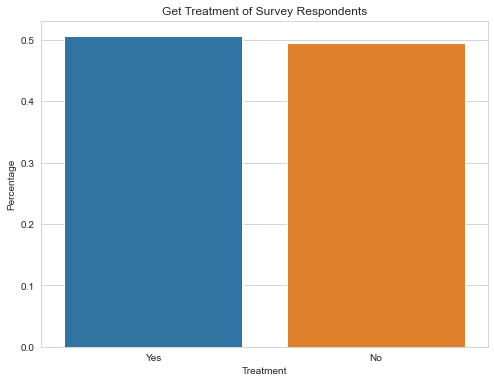

In [16]:
sns.set_style("whitegrid")
plt.figure(figsize = (8,6))
eda_percentage = mh_eda['Treatment'].value_counts(normalize = True).rename_axis('Treatment').reset_index(name = 'Percentage')
sns.barplot(x = 'Treatment', y = 'Percentage', data = eda_percentage.head(10))
plt.title('Get Treatment of Survey Respondents')
plt.show()

* This is the respondents result of question, **'Have you get treatment for a mental health condition?'**.
* The percentage of respondents who want to get treatment is 50%. Workplaces that promote mental health and support people with mental disorders are more likely to reduce absenteeism, increase productivity and benefit from associated economic gains. If employees enjoy good mental health, employees can:
    * make the most of your potential,
    * cope with what life throws at you,
    * play a full part in your relationships, your workplace, and your community.
* I decided to separate them into 3 aspects to see what factors that company give so employees want to get a treatment:
    - Employee's profiling
    - Employee's work environtment
    - Employee's mental health facilities

### Profile of Respondents

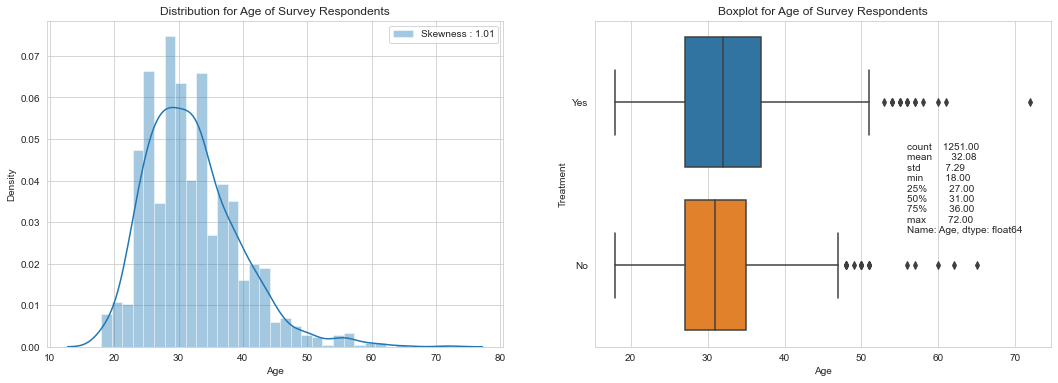

In [17]:
plt.figure(figsize = (18,6))
plt.subplot(1,2,1)
sns.distplot(mh_eda['Age'], label = 'Skewness : %.2f'%(mh_eda['Age'].skew()))
plt.legend(loc = 0, fontsize = 10)
plt.title('Distribution for Age of Survey Respondents')
plt.subplot(1,2,2)
sns.boxplot(x = "Age", y = "Treatment", data = mh_eda)
plt.title('Boxplot for Age of Survey Respondents')
age = str(mh_eda['Age'].describe().round(2))
plt.text(56, 0.80, age)
plt.show()

#### Skewness
- Based on the plot, **the skewness score is 1.01, which means the data are highly skewed and with Positive skewness** where the mode is smaller than mean or median.
- It's indicated that most of the employees that fill the survey around the end 20s to early 40s. I assume that they on between mid to senior-level positions. **The distribution of ages is right-skewed which is expected as the tech industry tends to have younger employees**. From an article that I read, young (usually white, mostly male) faces of start-up founders like Mark Zuckerberg and other “tech bros” have become the symbol and stereotypical image that tends to represent the tech industry.

#### Boxplot
- From the boxplot, there is no statistically significant difference of ages between respondents that get treatment and no treatment.

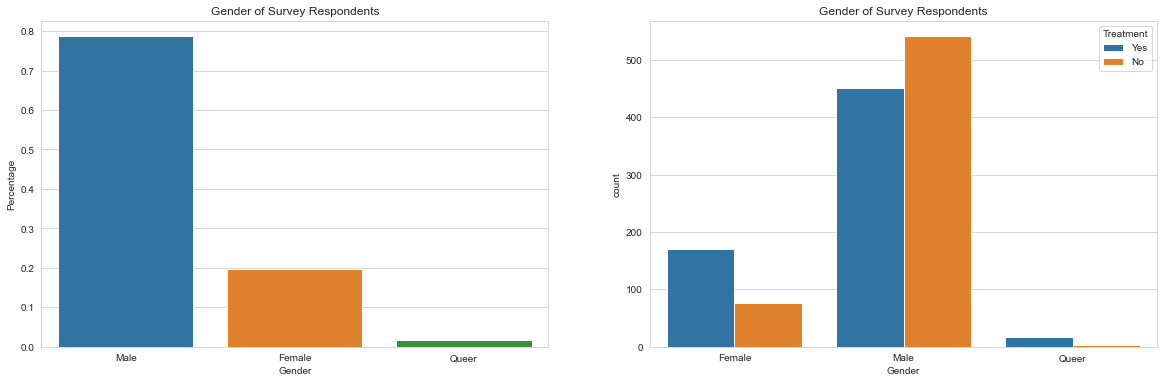

In [18]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
eda_percentage = mh_eda['Gender'].value_counts(normalize = True).rename_axis('Gender').reset_index(name = 'Percentage')
sns.barplot(x = 'Gender', y = 'Percentage', data = eda_percentage.head(10))
plt.title('Gender of Survey Respondents')
plt.subplot(1,2,2)
sns.countplot(mh_eda['Gender'], hue = mh_eda['Treatment'])
plt.title('Gender of Survey Respondents')
plt.show()

* This is the respondents result of question, **'What is your gender identities?'**.
* **Almost 79% of respondents are male**, not surprisingly, especially in the tech field. The very large gap between men and women causes higher competitive pressure for women than men. Based on the plot, female that want to get treatment is high around 70%. Maybe some of them get sexual harrassment or racism at work because female are scarce in the tech industry.
* There is a Queer entry of less than 2%. Although the percentage of queer is very low, it still deserves to dig out some new insights. For example, such a small proportion can show a significant difference in the count of who wants the treatments, indicating that for the queer, mental health problems are serious too. In my opinion, maybe they received hate speech or discrimination in the workplace.

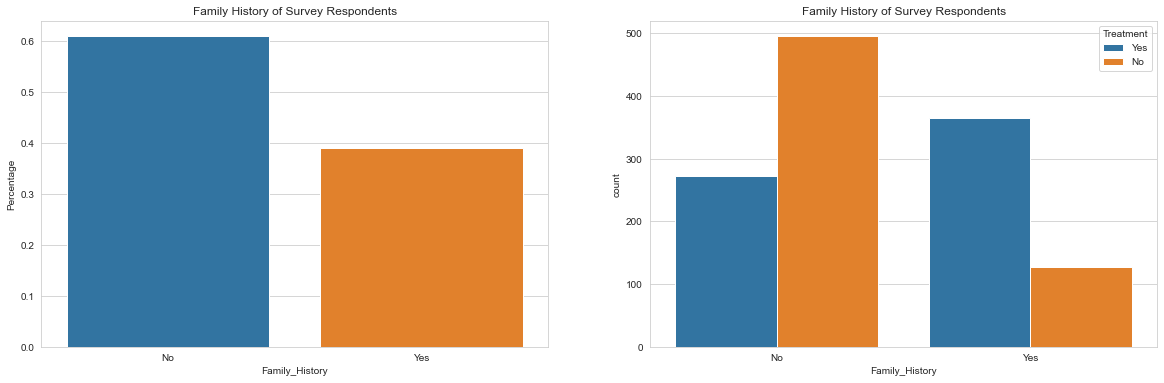

In [19]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
eda_percentage = mh_eda['Family_History'].value_counts(normalize = True).rename_axis('Family_History').reset_index(name = 'Percentage')
sns.barplot(x = 'Family_History', y = 'Percentage', data = eda_percentage)
plt.title('Family History of Survey Respondents')
plt.subplot(1,2,2)
sns.countplot(mh_eda['Family_History'], hue = mh_eda['Treatment'])
plt.title('Family History of Survey Respondents')
plt.show()

* This is the respondents result of question, **'Do you have a family history of mental illness?'**.
* From 40% of respondents who say that they have a family history of mental illness, the plot shows that they significantly want to get treatment rather than without a family history. This is acceptable, remember the fact that people with a family history pay more attention to mental illness. Family history is a significant risk factor for many mental health disorders. The apple does not fall far from the tree, as it is relatively common for families with mental illness symptoms to have one or more relatives with histories of similar difficulties.

### Work Environment of Respondents

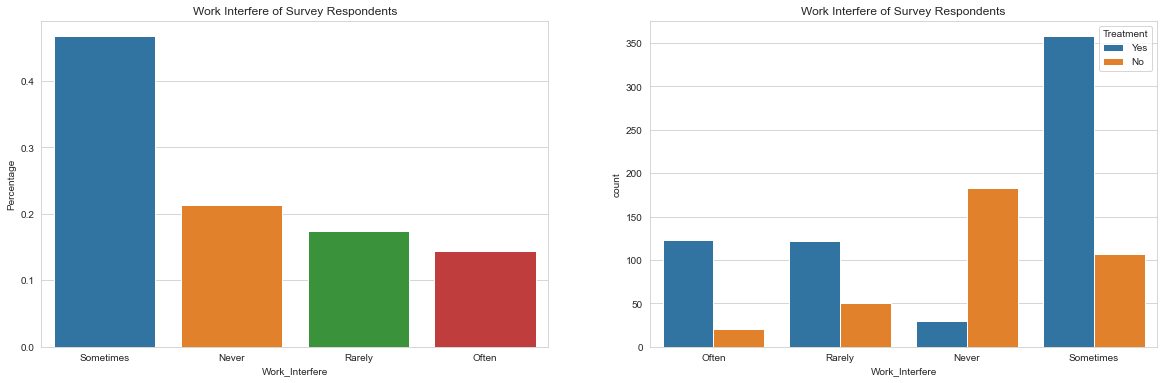

In [20]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
eda_percentage = mh_eda['Work_Interfere'].value_counts(normalize = True).rename_axis('Work_Interfere').reset_index(name = 'Percentage')
sns.barplot(x = 'Work_Interfere', y = 'Percentage', data = eda_percentage)
plt.title('Work Interfere of Survey Respondents')
plt.subplot(1,2,2)
sns.countplot(mh_eda['Work_Interfere'], hue = mh_eda['Treatment'])
plt.title('Work Interfere of Survey Respondents')
plt.show()

* This is the respondents result of question, **'If you have a mental health condition, do you feel that it interferes with your work?'**.
* About 78% of respondents have experienced interference at work with a ratio of rarely, sometimes, and frequently.
* Mental health conditions sometimes become an interfere while working about 45%. The plots prove that almost 80% want to get treatment. But **it's surprising to know even mental health never has interfered at work, there is a little group that still want to get treatment before it become a job stress**. It can be triggered by the requirements of the job do not match the capabilities, resources or needs of the worker.

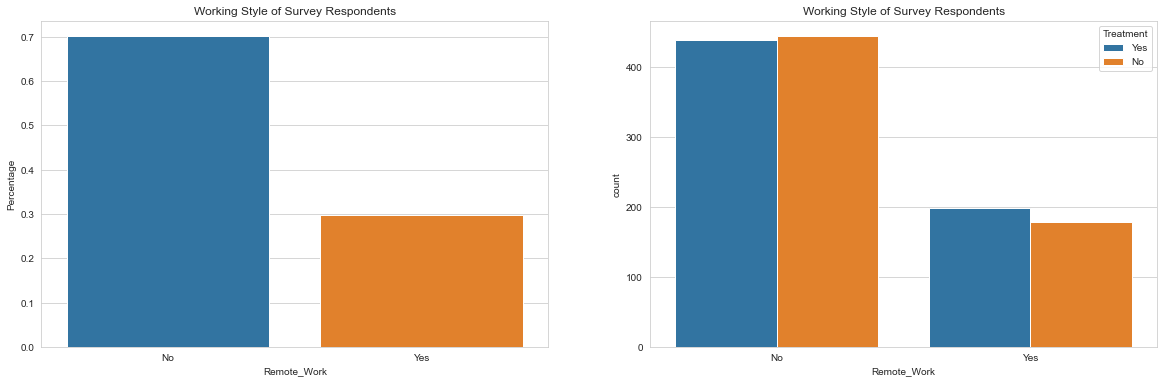

In [21]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
eda_percentage = mh_eda['Remote_Work'].value_counts(normalize = True).rename_axis('Remote_Work').reset_index(name = 'Percentage')
sns.barplot(x = 'Remote_Work', y = 'Percentage', data = eda_percentage)
plt.title('Working Style of Survey Respondents')
plt.subplot(1,2,2)
sns.countplot(mh_eda['Remote_Work'], hue = mh_eda['Treatment'])
plt.title('Working Style of Survey Respondents')
plt.show()

* This is the respondents result of question, **'Do you work remotely (outside of an office) at least 50% of the time?'**.
* Around 70% of respondents don't work remotely, which means the biggest factor of mental health disorder came up triggered on the workplace. On the other side, it has slightly different between an employee that want to get treatment and don't want to get a treatment. But it's getting interesting when we see a respondent who works 50% of the workday remotely. The employee who want to get treatment is a little bit higher. I have no idea why those employees work remotely to analyze more because the data doesn't provide that information. 

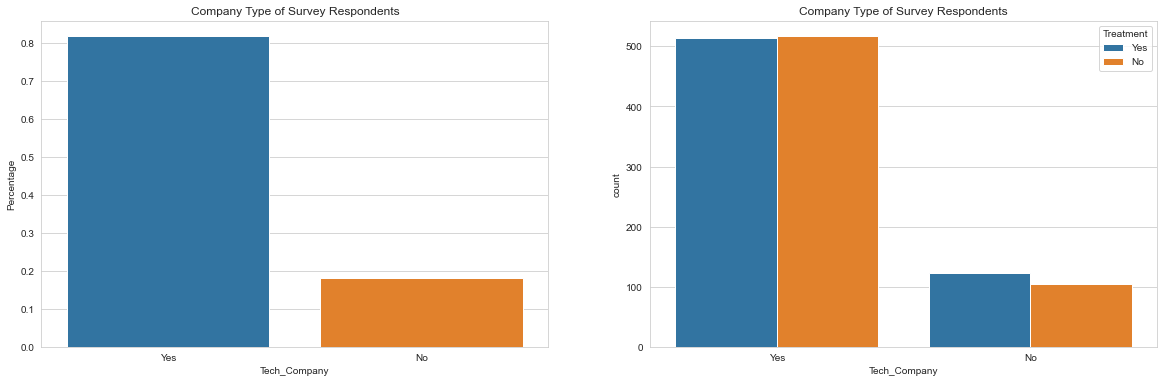

In [22]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
eda_percentage = mh_eda['Tech_Company'].value_counts(normalize = True).rename_axis('Tech_Company').reset_index(name = 'Percentage')
sns.barplot(x = 'Tech_Company', y = 'Percentage', data = eda_percentage)
plt.title('Company Type of Survey Respondents')
plt.subplot(1,2,2)
sns.countplot(mh_eda['Tech_Company'], hue = mh_eda['Treatment'])
plt.title('Company Type of Survey Respondents')
plt.show()

* This is the respondents result of question, **'Is your employer primarily a tech company/organization?'**.
* Even the main target of the survey is the tech field, there are 18% of companies belong to the non-tech field. But it can be seen from the plot whether the company belongs to the tech field or not, mental health still becomes a big problem. I think the environment affects a lot of employees and some of them can't take it for granted like abuse at the workplace.
* However, I found that the number of employees in the technology field that want to get treatment is slightly lower than no treatment. But the non-technical field is the opposite. **Maybe the non-tech company give more support for employee to get treatment?**

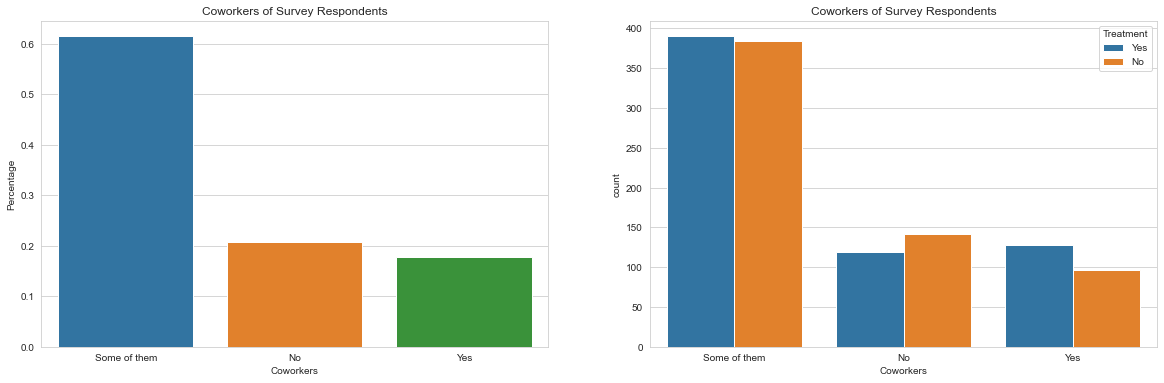

In [23]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
eda_percentage = mh_eda['Coworkers'].value_counts(normalize = True).rename_axis('Coworkers').reset_index(name = 'Percentage')
sns.barplot(x = 'Coworkers', y = 'Percentage', data = eda_percentage)
plt.title('Coworkers of Survey Respondents')
plt.subplot(1,2,2)
sns.countplot(mh_eda['Coworkers'], hue = mh_eda['Treatment'])
plt.title('Coworkers of Survey Respondents')
plt.show()

* This is the respondents result of question, **'Would you be willing to discuss a mental health issue with your coworkers?'**.
* From 18% of respondents who say yes to discuss it with coworkers, 60% of them want to get treatment. 
* About 60% of respondents decide to discuss some of them with coworkers. Employees who do that and want to get treatment are half of them. Let's see if the respondent will discuss it with a supervisor or not.

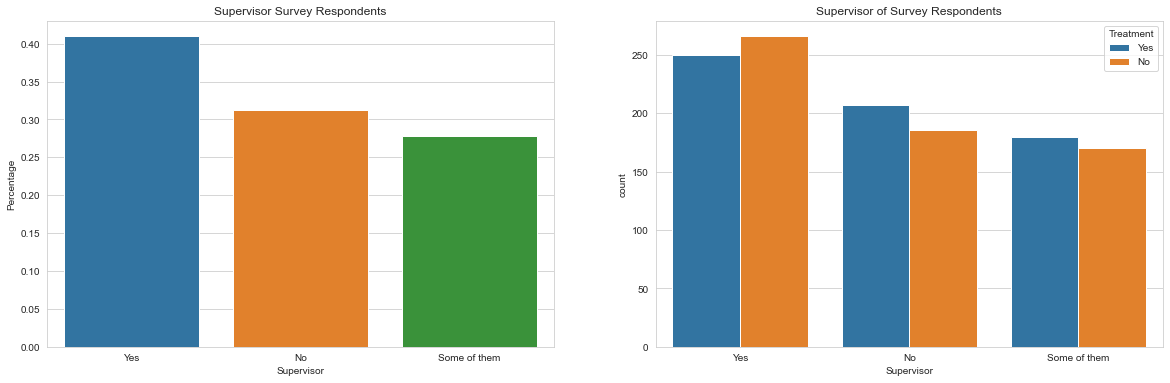

In [24]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
eda_percentage = mh_eda['Supervisor'].value_counts(normalize = True).rename_axis('Supervisor').reset_index(name = 'Percentage')
sns.barplot(x = 'Supervisor', y = 'Percentage', data = eda_percentage)
plt.title('Supervisor Survey Respondents')
plt.subplot(1,2,2)
sns.countplot(mh_eda['Supervisor'], hue = mh_eda['Treatment'])
plt.title('Supervisor of Survey Respondents')
plt.show()

* This is the respondents result of question, **'Would you be willing to discuss a mental health issue with your direct supervisor(s)?'**.
* From 40% of respondents who say yes to discuss with supervisor, only 55% of them that want to get treatment. I think maybe talking to someone in a higher position could help the relief. It's the opposite while employees discuss with coworkers.

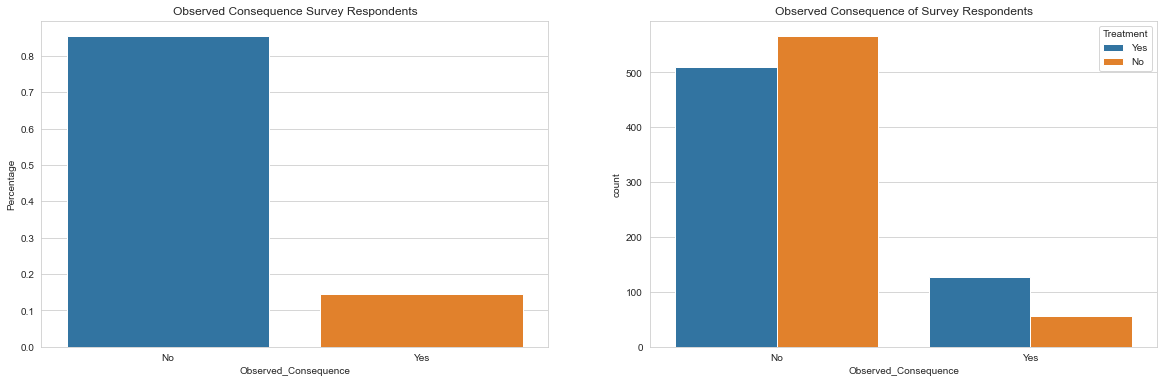

In [25]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
eda_percentage = mh_eda['Observed_Consequence'].value_counts(normalize = True).rename_axis('Observed_Consequence').reset_index(name = 'Percentage')
sns.barplot(x = 'Observed_Consequence', y = 'Percentage', data = eda_percentage)
plt.title('Observed Consequence Survey Respondents')
plt.subplot(1,2,2)
sns.countplot(mh_eda['Observed_Consequence'], hue = mh_eda['Treatment'])
plt.title('Observed Consequence of Survey Respondents')
plt.show()

* This is the respondents result of question, **'Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?'**.
* From 15% of respondents who say yes about knowing the negative consequences for coworkers with mental heatlh condition, almost 70% of them that want to get treatment. After the employee knows about the negative consequences, it becomes a good trigger for someone to get treatment to prevent mental health conditions.

### Mental Health Facilities of Respondents

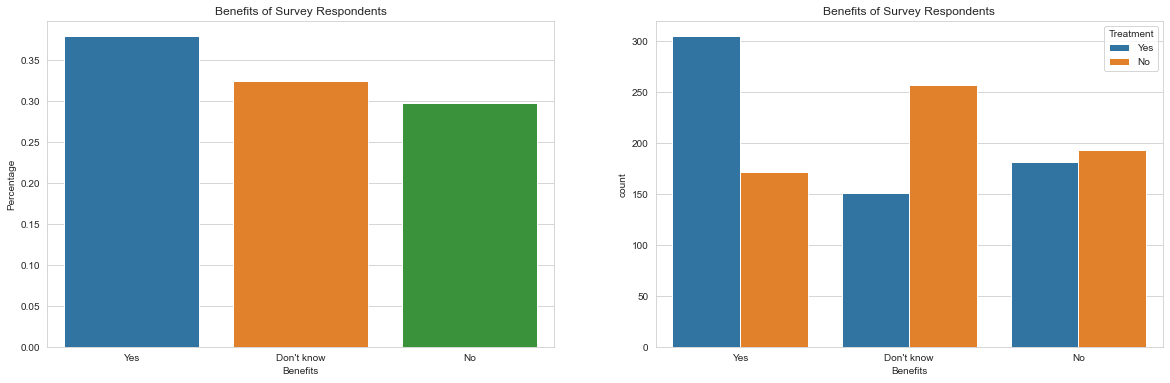

In [26]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
eda_percentage = mh_eda['Benefits'].value_counts(normalize = True).rename_axis('Benefits').reset_index(name = 'Percentage')
sns.barplot(x = 'Benefits', y = 'Percentage', data = eda_percentage)
plt.title('Benefits of Survey Respondents')
plt.subplot(1,2,2)
sns.countplot(mh_eda['Benefits'], hue = mh_eda['Treatment'])
plt.title('Benefits of Survey Respondents')
plt.show()

* This is the respondents result of question, **'Does your employer provide mental health benefits?'**.
* Only 35% of respondents know about mental health benefits that the company provides for them.
* For employees who know the benefits, almost 60% of the employees want to get treatment. Surprisingly, there is an employee who doesn't know and says that the company doesn't provide still want to get treatment. I assume that maybe the company can't provide it properly because of budgeting or financial struggling.

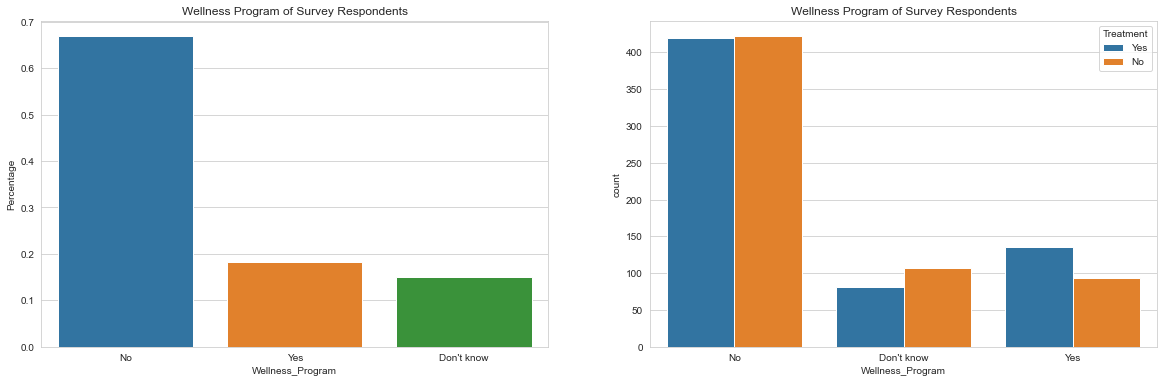

In [27]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
eda_percentage = mh_eda['Wellness_Program'].value_counts(normalize = True).rename_axis('Wellness_Program').reset_index(name = 'Percentage')
sns.barplot(x = 'Wellness_Program', y = 'Percentage', data = eda_percentage)
plt.title('Wellness Program of Survey Respondents')
plt.subplot(1,2,2)
sns.countplot(mh_eda['Wellness_Program'], hue = mh_eda['Treatment'])
plt.title('Wellness Program of Survey Respondents')
plt.show()

* This is the respondents result of question, **'Has your employer ever discussed mental health as part of an employee wellness program?'**.
* About 19% of the repondents say yes about become a part of employee wellness program and 60% of employee want to get treatment. After become a part of wellness program, i assume that employee feels a good vibe about it.
* More than 65% of respondents say that there aren't any wellness programs that provide by their company. But half of the respondents want to get treatment, which means the company need to provide it soon. **Based on my curiosity about company's benefit before, I think it makes sense if it's about company budgeting. I know it will spend a lot of money, moreover, the company has a lot of employees to taking care of. My second thought, it's still about budgeting but for a small company, it's will be a lot of struggle**.

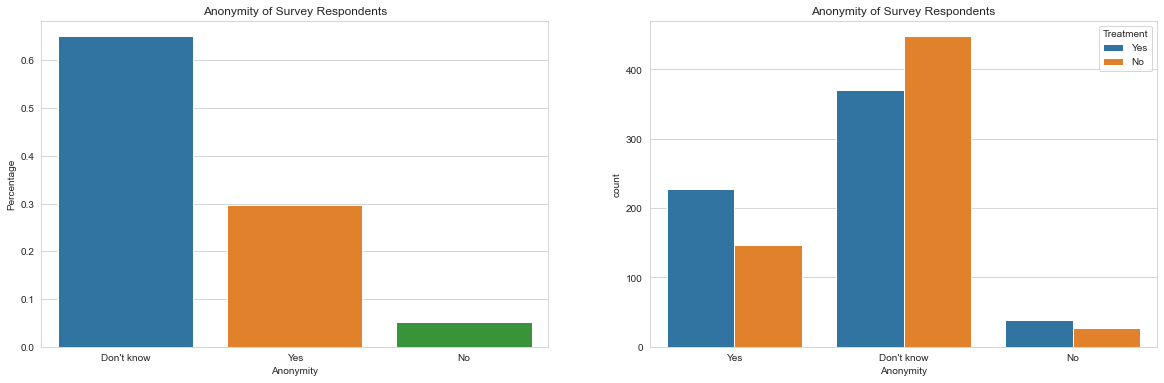

In [28]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
eda_percentage = mh_eda['Anonymity'].value_counts(normalize = True).rename_axis('Anonymity').reset_index(name = 'Percentage')
sns.barplot(x = 'Anonymity', y = 'Percentage', data = eda_percentage)
plt.title('Anonymity of Survey Respondents')
plt.subplot(1,2,2)
sns.countplot(mh_eda['Anonymity'], hue = mh_eda['Treatment'])
plt.title('Anonymity of Survey Respondents')
plt.show()

* This is the respondents result of question, **'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?'**.
* About 30% of respondents say yes if their anonymity is protected while taking advantage of mental health or substance abuse treatment resources and almost 65% of employees want to get treatment. The employee feels that the company protected their privacy and it's a good move for the company to build trust with their employees. Because of that, the employee wants to get treatment to be better.

###  Conclusion

Nearly 86% of employees report improved work performance and lower rates of absenteeism after receiving treatment for depression, according to an April 2018 article in the Journal of Occupational and Environmental Medicine. This means big gains in retention and productivity for employers. By providing employees access to mental health benefits, the company can begin to create a culture of understanding and compassion at the tech company. And having employees who feel cared for and happy isn’t just good, it’s good business.

#### Based on profiling the respondents
* Companies must know that gender and family history greatly influence the decision to get treatment for employees. So if the company wants to provide more support, the company must make an assessment of the employee's personality because different characters can determine different needs. Age can also be a trigger, considering that most of them are young so there is a high chance that they will be open-minded to get treatment.

#### Based on the work environment of respondents
* Work interference is the most influential of employees who want to get treatment. This means the company should consider providing facilities to anticipate job stress on employees. Some of the companies decide to make a private room or silent room in case employees suddenly feel stress and need a private moment to relieve.

#### Based on the mental health facilities of respondents
* The company needs to provide a good benefit for employees so they can maintain their mental health. If the company can don't have resources for it, there are so many third parties who can be hired to maintain a wellness program for the company. Building trust like keep private about whom employee that gets treatment also can also give a trigger for employee want to get treatment.

# PreProcessing

***Preprocessing Scheme***

- OneHotEncoding: Gender, Family History, Employee Numbers, Remote Work, Tech Company, Benefits, Care Options, Wellness Program, Seek Help, Anonymity, Medical Leave, Mental Health Consequence, Physical Health Consequence, Coworkers, Supervisor, Mental Health Interview, Physical Health Interview, Mental VS Physical, Observed Consequence
    * Simple Imputer Most Frequent: Self Employed, Work Interfere
- Iterative Impute: Age
- Target: Treatment

In [29]:
mode_onehot_pipe = Pipeline([
    ('encoder', SimpleImputer(strategy = 'most_frequent')),
    ('one hot encoder', OneHotEncoder(handle_unknown = 'ignore'))])

transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(handle_unknown = 'ignore'), ['Gender', 'Family_History', 'Employee_Numbers',
                                                           'Remote_Work', 'Tech_Company', 'Benefits', 'Care_Options',
                                                           'Wellness_Program', 'Seek_Help', 'Anonymity',
                                                           'Medical_Leave', 'Mental_Health_Consequence',
                                                           'Physical_Health_Consequence', 'Coworkers', 'Supervisor',
                                                           'Mental_Health_Interview', 'Physical_Health_Interview',
                                                           'Mental_VS_Physical', 'Observed_Consequence']),
    ('mode_onehot_pipe', mode_onehot_pipe, ['Self_Employed', 'Work_Interfere']),
    ('iterative', IterativeImputer(max_iter = 10, random_state = 0), ['Age'])])

***Define Target Data***

In [30]:
mh['Treatment'].value_counts()/mh.shape[0]*100

Yes    50.595711
No     49.404289
Name: Treatment, dtype: float64

* The data looks normal. It doesn't indicate imbalanced data

In [31]:
mh['Treatment'] = np.where(mh['Treatment'] == 'Yes', 1, 0)

* *0 = No Treatment*
* *1 = Get Treatment*

        - TN: Employee's Mental Health predict with No Treatment and the actual is No Treatment
        - TP: Employee's Mental Health predict with Get Treatment and the actual is Get Treatment
        - FP: Employee's Mental Health predict with Get Treatment and the actual is No Treatment
        - FN: Employee's Mental Health predict with No Treatment and the actual is Get Treatment

Actions:
* FN: There is a feeling of excessive stress and anxiety at work. It's not detected in employees do their work performance decreases due to prediction errors.
* FP: It would be nice if the company provides mental health treatment to them so that employees can maintain mental health at the workplace. 

    -> In terms of mental health, the company should know what factors for employee  decide to get treatment. To anticipate error prediction, the metric that I use to determine the predicted score is the recall score (FN).

In [32]:
X = mh.drop('Treatment', axis = 1)
y = mh['Treatment']

***Splitting Data***

In [33]:
X.shape

(1259, 22)

- After all data cleaning process, I have 23 features column left.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   stratify = y,
                                                    test_size = 0.3,
                                                   random_state = 2222)

* I use 0.3 as default score for test_size and X.shape for random_state so the data will be devided equally.

# Modeling

***Define Model***

- In supervised learning, algorithms learn from labeled data. In this case, I use Classification technique for determining which class is yes and no.
- I use 3 basic models and 4 ensemble models to predict.
- Basic models:
    * Logistic Regression (logreg)
    * Decision Tree Classifier (tree)
    * K-Nearest Neighbor (knn)
- Ensemble models:
    * Random Forest Classifier (rf)
    * Ada Boost Classifier (ada)
    * Gradient Boosting Classifier (grad)
    * XGB Classifier (xgboost)

In [35]:
logreg = LogisticRegression()
tree = DecisionTreeClassifier(random_state = 2222)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state = 2222)
ada = AdaBoostClassifier(random_state = 2222)
grad = GradientBoostingClassifier(random_state = 2222)
xgboost = XGBClassifier(random_state = 2222)

# Cross Validation

In [36]:
logreg_pipe = Pipeline([('transformer', transformer), ('logreg', logreg)])
tree_pipe = Pipeline([('transformer', transformer), ('tree', tree)])
knn_pipe = Pipeline([('transformer', transformer), ('knn', knn)])
rf_pipe = Pipeline([('transformer', transformer), ('rf', rf)])
ada_pipe = Pipeline([('transformer', transformer), ('ada', ada)])
grad_pipe = Pipeline([('transformer', transformer), ('grad', grad)])
xgb_pipe = Pipeline([('transformer', transformer), ('xgboost', xgboost)])

def model_evaluation(model, metric):
    model_cv = cross_val_score(model, X_train, y_train, cv = StratifiedKFold(n_splits = 5), scoring = metric)
    return model_cv

logreg_pipe_cv = model_evaluation(logreg_pipe, 'recall')
tree_pipe_cv = model_evaluation(tree_pipe, 'recall')
knn_pipe_cv = model_evaluation(knn_pipe, 'recall')
rf_pipe_cv = model_evaluation(rf_pipe, 'recall')
ada_pipe_cv = model_evaluation(ada_pipe, 'recall')
grad_pipe_cv = model_evaluation(grad_pipe, 'recall')
xgb_pipe_cv = model_evaluation(xgb_pipe, 'recall')

for model in [logreg_pipe, tree_pipe, knn_pipe, rf_pipe, ada_pipe, grad_pipe, xgb_pipe]:
    model.fit(X_train, y_train)

score_cv = [logreg_pipe_cv.round(5), tree_pipe_cv.round(5), knn_pipe_cv.round(5),
            rf_pipe_cv.round(5), ada_pipe_cv.round(5), grad_pipe_cv.round(5), xgb_pipe_cv.round(5)]
score_mean = [logreg_pipe_cv.mean(), tree_pipe_cv.mean(), knn_pipe_cv.mean(), rf_pipe_cv.mean(),
              ada_pipe_cv.mean(), grad_pipe_cv.mean(), xgb_pipe_cv.mean()]
score_std = [logreg_pipe_cv.std(), tree_pipe_cv.std(), knn_pipe_cv.std(), rf_pipe_cv.std(),
             ada_pipe_cv.std(), grad_pipe_cv.std(), xgb_pipe_cv.std()]
score_recall_score = [recall_score(y_test, logreg_pipe.predict(X_test)),
            recall_score(y_test, tree_pipe.predict(X_test)), 
            recall_score(y_test, knn_pipe.predict(X_test)), 
            recall_score(y_test, rf_pipe.predict(X_test)),
            recall_score(y_test, ada_pipe.predict(X_test)),
            recall_score(y_test, grad_pipe.predict(X_test)),
            recall_score(y_test, xgb_pipe.predict(X_test))]
method_name = ['Logistic Regression', 'Decision Tree Classifier', 'KNN Classifier', 'Random Forest Classifier',
               'Ada Boost Classifier', 'Gradient Boosting Classifier', 'XGB Classifier']
cv_summary = pd.DataFrame({
    'method': method_name,
    'cv score': score_cv,
    'mean score': score_mean,
    'std score': score_std,
    'recall score': score_recall_score
})
cv_summary

[13:14:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:14:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:14:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:14:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

,method,cv score,mean score,std score,recall score
0,Logistic Regression,"[0.75556, 0.70787, 0.74157, 0.69663, 0.75281]",0.730886,0.024112,0.701571
1,Decision Tree Classifier,"[0.65556, 0.66292, 0.60674, 0.67416, 0.66292]",0.652459,0.023620,0.617801
2,KNN Classifier,"[0.52222, 0.60674, 0.52809, 0.59551, 0.60674]",0.571860,0.038399,0.570681
3,Random Forest Classifier,"[0.78889, 0.75281, 0.74157, 0.76404, 0.74157]",0.757778,0.017647,0.664921
4,Ada Boost Classifier,"[0.75556, 0.7191, 0.74157, 0.68539, 0.73034]",0.726392,0.023793,0.722513
5,Gradient Boosting Classifier,"[0.82222, 0.7191, 0.73034, 0.77528, 0.77528]",0.764444,0.036858,0.712042
6,XGB Classifier,"[0.77778, 0.70787, 0.73034, 0.74157, 0.76404]",0.744320,0.024660,0.691099


- From the cross validation process, there are 2 models that pop up with high precision scores. The first is Logistic Regression for the basic model and the second is Ada Boost Classifier for the ensemble model. But I decide to continue with Logistic Regression because Ada Boost Classifier is really heavy to process.
- Let's tune using Logistic Regression model.

# HyperParam Tuning

In [37]:
lr_estimator = Pipeline([
    ('transformer', transformer),
    ('model', logreg)])

hyperparam_space = {
    'model__C': [ 1, 0.5, 0.1, 0.05, 0.01],
    'model__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'model__class_weight': ['balanced', 'dict'],
    'model__max_iter': [100, 200, 300],
    'model__multi_class': ['auto', 'ovr', 'multinomial'],
    'model__random_state': [2222]
}

grid_lr = GridSearchCV(
                lr_estimator,
                param_grid = hyperparam_space,
                cv = StratifiedKFold(n_splits = 5),
                scoring = 'recall',
                n_jobs = -1)

grid_lr.fit(X_train, y_train)

print('best score', grid_lr.best_score_)
print('best param', grid_lr.best_params_)

best score 0.7376279650436953
best param {'model__C': 0.5, 'model__class_weight': 'dict', 'model__max_iter': 100, 'model__multi_class': 'auto', 'model__random_state': 2222, 'model__solver': 'newton-cg'}


- C score is 0.5.
- The solver is newton-cg.
- The class_weight is dict.
- The max_iter score is 100.
- The multi_class is auto.
- The random_state is 2222.

In [38]:
logreg_pipe.fit(X_train, y_train)
recall_logreg = (recall_score(y_test, logreg_pipe.predict(X_test)))

grid_lr.best_estimator_.fit(X_train, y_train)
recall_grid = (recall_score(y_test, grid_lr.predict(X_test)))

score_list = [recall_logreg, recall_grid]
method_name = ['Logistic Regression Before Tuning', 'Logistic Regression After Tuning']
best_summary = pd.DataFrame({
    'method': method_name,
    'score': score_list
})
best_summary

,method,score
0,Logistic Regression Before Tuning,0.701571
1,Logistic Regression After Tuning,0.706806


- This is the comparison between before tuning score and after tuning score using Logistic Regression. I choose to use Logistic Regression after tuning score in this section.

# Feature Selection using Tuning Result

In [39]:
transformer.transformers_

[('one hot',
  OneHotEncoder(handle_unknown='ignore'),
  ['Gender',
   'Family_History',
   'Employee_Numbers',
   'Remote_Work',
   'Tech_Company',
   'Benefits',
   'Care_Options',
   'Wellness_Program',
   'Seek_Help',
   'Anonymity',
   'Medical_Leave',
   'Mental_Health_Consequence',
   'Physical_Health_Consequence',
   'Coworkers',
   'Supervisor',
   'Mental_Health_Interview',
   'Physical_Health_Interview',
   'Mental_VS_Physical',
   'Observed_Consequence']),
 ('mode_onehot_pipe',
  Pipeline(steps=[('encoder', SimpleImputer(strategy='most_frequent')),
                  ('one hot encoder', OneHotEncoder(handle_unknown='ignore'))]),
  ['Self_Employed', 'Work_Interfere']),
 ('iterative', IterativeImputer(random_state=0), ['Age'])]

In [40]:
transformer.transformers_[0][1].get_feature_names()

array(['x0_Female', 'x0_Male', 'x0_Queer', 'x1_No', 'x1_Yes', 'x2_1-5',
       'x2_100-500', 'x2_26-100', 'x2_500-1000', 'x2_6-25',
       'x2_More than 1000', 'x3_No', 'x3_Yes', 'x4_No', 'x4_Yes',
       "x5_Don't know", 'x5_No', 'x5_Yes', 'x6_No', 'x6_Not sure',
       'x6_Yes', "x7_Don't know", 'x7_No', 'x7_Yes', "x8_Don't know",
       'x8_No', 'x8_Yes', "x9_Don't know", 'x9_No', 'x9_Yes',
       "x10_Don't know", 'x10_Somewhat difficult', 'x10_Somewhat easy',
       'x10_Very difficult', 'x10_Very easy', 'x11_Maybe', 'x11_No',
       'x11_Yes', 'x12_Maybe', 'x12_No', 'x12_Yes', 'x13_No',
       'x13_Some of them', 'x13_Yes', 'x14_No', 'x14_Some of them',
       'x14_Yes', 'x15_Maybe', 'x15_No', 'x15_Yes', 'x16_Maybe', 'x16_No',
       'x16_Yes', "x17_Don't know", 'x17_No', 'x17_Yes', 'x18_No',
       'x18_Yes'], dtype=object)

In [41]:
transformer.transformers_[1][1][1].get_feature_names()

array(['x0_No', 'x0_Yes', 'x1_Never', 'x1_Often', 'x1_Rarely',
       'x1_Sometimes'], dtype=object)

In [42]:
features = list(transformer.transformers_[0][1].get_feature_names())+list(transformer.transformers_[1][1][1].get_feature_names())+['Age']
coef_table = pd.DataFrame({'coef': grid_lr.best_estimator_[1].coef_.flatten()}, index = features)
abs(coef_table).sort_values('coef', ascending = False)

,coef
x1_Never,1.775759
x1_Often,1.315276
x1_Yes,0.738512
x1_No,0.738510
x13_No,0.617663
x13_Yes,0.567563
x1_Rarely,0.548121
x6_Yes,0.531456
x0_Male,0.470710
x9_Yes,0.406047


<AxesSubplot:>

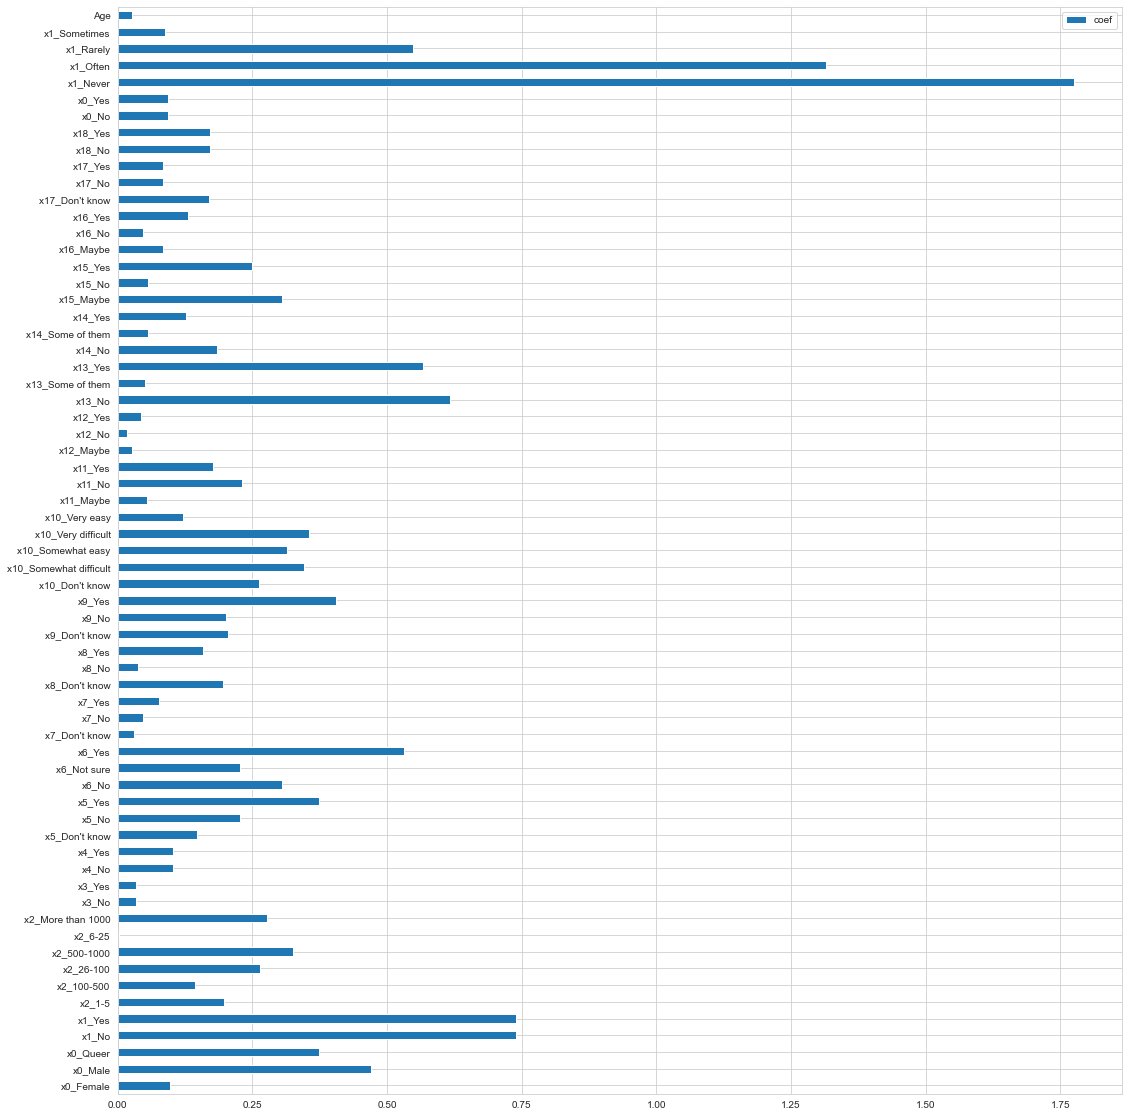

In [43]:
abs(coef_table).plot(kind = 'barh', figsize = (18,20))

* Based on selecting features based on coefficient score, I decided to drop 4 features manually who gets a score under 0.05 for all answer choices for every feature. There are Age, x3(Remote_work), x7(Wellness_Program), x12(Physical_Health_Consequence).

# Re-run Using Feature Selection

***Preprocessing Scheme***

- OneHotEncoding: Gender, Family History, Employee Numbers, Tech Company, Benefits, Care Options, Seek Help, Anonymity, Medical Leave, Mental Health Consequence, Coworkers, Supervisor, Mental Health Interview, Physical Health Interview, Mental_VS_Physical, Observed_Consequence
    * Mode: Self Employed, Work Interfere
- Target: Treatment

In [44]:
mh_tuning = mh.copy()
mh_tuning.drop(columns = ['Age', 'Remote_Work', 'Wellness_Program', 'Physical_Health_Consequence'], inplace = True)
mh_tuning.head()

,Gender,Self_Employed,Family_History,Treatment,Work_Interfere,Employee_Numbers,Tech_Company,Benefits,Care_Options,Seek_Help,Anonymity,Medical_Leave,Mental_Health_Consequence,Coworkers,Supervisor,Mental_Health_Interview,Physical_Health_Interview,Mental_VS_Physical,Observed_Consequence
0,Female,NaN,No,1,Often,6-25,Yes,Yes,Not sure,Yes,Yes,Somewhat easy,No,Some of them,Yes,No,Maybe,Yes,No
1,Male,NaN,No,0,Rarely,More than 1000,No,Don't know,No,Don't know,Don't know,Don't know,Maybe,No,No,No,No,Don't know,No
2,Male,NaN,No,0,Rarely,6-25,Yes,No,No,No,Don't know,Somewhat difficult,No,Yes,Yes,Yes,Yes,No,No
3,Male,NaN,Yes,1,Often,26-100,Yes,No,Yes,No,No,Somewhat difficult,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,Male,NaN,No,0,Never,100-500,Yes,Yes,No,Don't know,Don't know,Don't know,No,Some of them,Yes,Yes,Yes,Don't know,No


In [45]:
mode_onehot_pipe_second = Pipeline([
    ('encoder', SimpleImputer(strategy = 'most_frequent')),
    ('one hot encoder', OneHotEncoder(handle_unknown = 'ignore'))])

transformer_second = ColumnTransformer([
    ('one hot', OneHotEncoder(handle_unknown = 'ignore'), ['Gender', 'Family_History', 'Employee_Numbers',
                                                           'Tech_Company', 'Benefits', 'Care_Options', 
                                                           'Seek_Help', 'Anonymity', 'Medical_Leave',
                                                           'Mental_Health_Consequence', 'Coworkers',
                                                           'Supervisor','Mental_Health_Interview',
                                                           'Physical_Health_Interview', 'Mental_VS_Physical',
                                                           'Observed_Consequence',]),
    ('mode_onehot_pipe', mode_onehot_pipe_second, ['Self_Employed', 'Work_Interfere']),])

In [46]:
X_select = mh_tuning.drop('Treatment', axis = 1)
y_select = mh_tuning['Treatment']

In [47]:
X_select_train, X_select_test, y_select_train, y_select_test = train_test_split(X_select,y_select,
                                                   stratify = y_select,
                                                    test_size = 0.3,
                                                   random_state = 2222)

In [48]:
logreg_second = LogisticRegression(C = 0.5, class_weight = 'dict', max_iter = 100,
                                   multi_class = 'auto', random_state = 2222, solver = 'newton-cg')
logreg_second_pipe = Pipeline([('transformer', transformer_second), ('model', logreg_second)])
logreg_second_pipe.fit(X_select_train, y_select_train)
print('After Feature Selection Process, the score is ', recall_score(y_select_test, logreg_second_pipe.predict(X_select_test)))

After Feature Selection Process, the score is  0.7277486910994765


- The score that used as a reference for predicting is 0.7277, which is similar to the tuning score before.

In [44]:
#mh_tuning[:100].drop('Treatment', axis = 1).to_html('/Users/zaki/Downloads/mh_tuning.html')

# Deployment

In [45]:
logreg_second_pipe.fit(X_select, y_select)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('one hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Family_History',
                                                   'Employee_Numbers',
                                                   'Tech_Company', 'Benefits',
                                                   'Care_Options', 'Seek_Help',
                                                   'Anonymity', 'Medical_Leave',
                                                   'Mental_Health_Consequence',
                                                   'Coworkers', 'Supervisor',
                                                   'Mental_Health_Interview',
                                                   'Physical_Health_Interview',
                                                   'Mental_VS_Physical',
                                      

In [46]:
file_name = 'Final_Project.sav'

pickle.dump(logreg_second_pipe, open(file_name,'wb'))

In [47]:
loaded_model = pickle.load(open(file_name,'rb'))
loaded_model.predict(X_select_test)

array([0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,

In [48]:
mh_predict = pd.DataFrame({
    'Gender': ['Female'],
    'Self_Employed': ['No'],
    'Family_History': ['Yes'],
    'Work_Interfere': ['Often'],
    'Employee_Numbers': ['100-500'],
    'Tech_Company': ['Yes'],
    'Benefits': ['Yes'],
    'Care_Options': ['Yes'],
    'Seek_Help': ['Yes'],
    'Anonymity': ['Yes'],
    'Medical_Leave': ['Somewhat easy'],
    'Mental_Health_Consequence': ['No'],
    'Coworkers': ['Some of them'],
    'Supervisor': ['Some of them'],
    'Mental_Health_Interview': ['No'],
    'Physical_Health_Interview': ['No'],
    'Mental_VS_Physical': ['No'],
    'Observed_Consequence': ['No']
})

In [49]:
mh_predict

,Gender,Self_Employed,Family_History,Work_Interfere,Employee_Numbers,Tech_Company,Benefits,Care_Options,Seek_Help,Anonymity,Medical_Leave,Mental_Health_Consequence,Coworkers,Supervisor,Mental_Health_Interview,Physical_Health_Interview,Mental_VS_Physical,Observed_Consequence
0,Female,No,Yes,Often,100-500,Yes,Yes,Yes,Yes,Yes,Somewhat easy,No,Some of them,Some of them,No,No,No,No


In [50]:
loaded_model.predict(mh_predict)

array([1])

In [51]:
loaded_model.predict_proba(mh_predict)

array([[0.0287118, 0.9712882]])